Implementation of DenseUnet to segment Retina Blood Vessels

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, tf_data, get_np_images

print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Defining parameters

h = 256
w = 256
channels = 3
batch_size = 8
buffer_size = 100
num_epochs = 200
lr = 1e-3
seed = 42
np.random.seed = seed

Loading the image and mask paths

In [4]:
train_path='DDRIVE/Train/Image'
train_mask_path='DDRIVE/Train/Mask'
test_path='DDRIVE/Train/Image'
test_mask_path='DDRIVE/Train/Mask'

X_train, Y_train = load_path(train_path, train_mask_path)
X_test, Y_test = load_path(test_path, test_mask_path)

Loading the image and masks to tensorflow dataset

In [5]:
Train = tf_data(X_train, Y_train, buffer_size, batch_size, num_epochs)
Test = tf_data(X_test, Y_test, buffer_size, batch_size, num_epochs)

Displaying the train and test images and mask

In [ ]:
for x, y in Train:
    f, plot = plt.subplots(1,2)
    plot[0].imshow(x[0])
    plot[1].imshow(y[0])
    plt.show();
    
for x, y in Test:
    f, plot = plt.subplots(1,2)
    plot[0].imshow(x[0])
    plot[1].imshow(y[0])
    plt.show();

In [6]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from Metrics import dice_coef, dice_loss, iou

In [7]:
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

In [8]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

#     x = Dropout(0.2)(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [9]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [10]:
def build_densenet121_unet(input_shape):
    
    inputs = Input(input_shape)

    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)
#     densenet.trainable = False

    s1 = densenet.get_layer("input_1").output
    s2 = densenet.get_layer("conv1/relu").output
    s3 = densenet.get_layer("pool2_relu").output
    s4 = densenet.get_layer("pool3_relu").output

    b1 = densenet.get_layer("pool4_relu").output

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

In [11]:
train_steps = len(X_train)//batch_size
test_steps = len(X_test)//batch_size
if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    test_steps += 1

input_shape = (h, w, 3)
model = build_densenet121_unet(input_shape)
model.compile(optimizer = Adam(lr), loss = dice_loss, metrics = [dice_coef, iou, Accuracy(), Recall(), Precision()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [12]:
#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose = 1, save_best_only = True)

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=200, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
]

results=model.fit(
    Train,
    validation_data = Test, 
    batch_size = batch_size, 
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    epochs = num_epochs, 
    callbacks=callbacks)

Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8377 - dice_coef: 0.1623 - iou: 0.0883 - accuracy: 0.0000e+00 - recall: 0.9513 - precision: 0.0891WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3/3 [==============================] - 9s 3s/step - loss: 0.8121 - dice_coef: 0.1939 - iou: 0.1076 - accuracy: 7.6294e-07 - recall: 0.9523 - precision: 0.1066 - val_loss: 0.8312 - val_dice_coef: 0.1728 - val_iou: 0.0947 - val_accuracy: 0.0000e+00 - val_recall: 1.0000 - val_precision: 0.0893
Epoch 2/200
3/3 [==============================] - 1s 375ms/step - loss: 0.7556 - dice_coef: 0.2491 - iou: 0.1424 - accuracy: 5.5695e-05 - recall: 0.8920 - precision: 0.1870 - val_loss: 0.8083 - val_dice_coef: 0.1936 - val_iou: 0.1072 - val_accura

3/3 [==============================] - 2s 516ms/step - loss: 0.5312 - dice_coef: 0.4667 - iou: 0.3044 - accuracy: 0.0039 - recall: 0.9631 - precision: 0.6101 - val_loss: 0.6428 - val_dice_coef: 0.3548 - val_iou: 0.2157 - val_accuracy: 0.0000e+00 - val_recall: 0.7370 - val_precision: 0.6210
Epoch 26/200
3/3 [==============================] - 1s 255ms/step - loss: 0.5208 - dice_coef: 0.4764 - iou: 0.3127 - accuracy: 0.0054 - recall: 0.9577 - precision: 0.6422 - val_loss: 0.6425 - val_dice_coef: 0.3554 - val_iou: 0.2161 - val_accuracy: 0.0000e+00 - val_recall: 0.7162 - val_precision: 0.6758
Epoch 27/200
3/3 [==============================] - 1s 282ms/step - loss: 0.5125 - dice_coef: 0.4887 - iou: 0.3234 - accuracy: 0.0054 - recall: 0.9583 - precision: 0.6393 - val_loss: 0.6357 - val_dice_coef: 0.3645 - val_iou: 0.2229 - val_accuracy: 0.0000e+00 - val_recall: 0.7344 - val_precision: 0.6408
Epoch 28/200
3/3 [==============================] - 1s 277ms/step - loss: 0.5011 - dice_coef: 0.4957 

3/3 [==============================] - 1s 262ms/step - loss: 0.2353 - dice_coef: 0.7629 - iou: 0.6169 - accuracy: 0.0198 - recall: 0.9584 - precision: 0.8898 - val_loss: 0.4229 - val_dice_coef: 0.5795 - val_iou: 0.4080 - val_accuracy: 8.9264e-04 - val_recall: 0.7042 - val_precision: 0.8977
Epoch 53/200
3/3 [==============================] - 2s 609ms/step - loss: 0.2233 - dice_coef: 0.7779 - iou: 0.6366 - accuracy: 0.0194 - recall: 0.9597 - precision: 0.9028 - val_loss: 0.4054 - val_dice_coef: 0.5954 - val_iou: 0.4239 - val_accuracy: 0.0010 - val_recall: 0.7310 - val_precision: 0.8728
Epoch 54/200
3/3 [==============================] - 1s 426ms/step - loss: 0.2183 - dice_coef: 0.7817 - iou: 0.6416 - accuracy: 0.0205 - recall: 0.9648 - precision: 0.8856 - val_loss: 0.3978 - val_dice_coef: 0.6030 - val_iou: 0.4317 - val_accuracy: 0.0012 - val_recall: 0.7208 - val_precision: 0.8957
Epoch 55/200
3/3 [==============================] - 1s 265ms/step - loss: 0.2062 - dice_coef: 0.7952 - iou: 0

3/3 [==============================] - 1s 265ms/step - loss: 0.0782 - dice_coef: 0.9211 - iou: 0.8538 - accuracy: 0.0318 - recall: 0.9802 - precision: 0.9701 - val_loss: 0.1967 - val_dice_coef: 0.8021 - val_iou: 0.6696 - val_accuracy: 0.0081 - val_recall: 0.7863 - val_precision: 0.9721
Epoch 80/200
3/3 [==============================] - 1s 331ms/step - loss: 0.0757 - dice_coef: 0.9237 - iou: 0.8582 - accuracy: 0.0318 - recall: 0.9795 - precision: 0.9723 - val_loss: 0.1741 - val_dice_coef: 0.8257 - val_iou: 0.7032 - val_accuracy: 0.0103 - val_recall: 0.8295 - val_precision: 0.9693
Epoch 81/200
3/3 [==============================] - 1s 412ms/step - loss: 0.0744 - dice_coef: 0.9231 - iou: 0.8573 - accuracy: 0.0324 - recall: 0.9808 - precision: 0.9713 - val_loss: 0.1767 - val_dice_coef: 0.8239 - val_iou: 0.7005 - val_accuracy: 0.0099 - val_recall: 0.8176 - val_precision: 0.9710
Epoch 82/200
3/3 [==============================] - 2s 535ms/step - loss: 0.0705 - dice_coef: 0.9294 - iou: 0.868

3/3 [==============================] - 1s 332ms/step - loss: 0.0405 - dice_coef: 0.9587 - iou: 0.9207 - accuracy: 0.0399 - recall: 0.9833 - precision: 0.9789 - val_loss: 0.0703 - val_dice_coef: 0.9297 - val_iou: 0.8687 - val_accuracy: 0.0183 - val_recall: 0.9487 - val_precision: 0.9787
Epoch 107/200
3/3 [==============================] - 1s 325ms/step - loss: 0.0396 - dice_coef: 0.9608 - iou: 0.9245 - accuracy: 0.0400 - recall: 0.9833 - precision: 0.9790 - val_loss: 0.0760 - val_dice_coef: 0.9238 - val_iou: 0.8585 - val_accuracy: 0.0181 - val_recall: 0.9354 - val_precision: 0.9786
Epoch 108/200
3/3 [==============================] - 1s 252ms/step - loss: 0.0391 - dice_coef: 0.9613 - iou: 0.9254 - accuracy: 0.0398 - recall: 0.9833 - precision: 0.9791 - val_loss: 0.0745 - val_dice_coef: 0.9266 - val_iou: 0.8633 - val_accuracy: 0.0183 - val_recall: 0.9369 - val_precision: 0.9786
Epoch 109/200
3/3 [==============================] - 1s 256ms/step - loss: 0.0385 - dice_coef: 0.9603 - iou: 0.

3/3 [==============================] - 1s 354ms/step - loss: 0.0303 - dice_coef: 0.9692 - iou: 0.9403 - accuracy: 0.0440 - recall: 0.9839 - precision: 0.9796 - val_loss: 0.0341 - val_dice_coef: 0.9661 - val_iou: 0.9344 - val_accuracy: 0.0299 - val_recall: 0.9829 - val_precision: 0.9796
Epoch 134/200
3/3 [==============================] - 1s 251ms/step - loss: 0.0302 - dice_coef: 0.9708 - iou: 0.9433 - accuracy: 0.0442 - recall: 0.9839 - precision: 0.9796 - val_loss: 0.0337 - val_dice_coef: 0.9663 - val_iou: 0.9348 - val_accuracy: 0.0302 - val_recall: 0.9830 - val_precision: 0.9796
Epoch 135/200
3/3 [==============================] - 2s 616ms/step - loss: 0.0298 - dice_coef: 0.9700 - iou: 0.9418 - accuracy: 0.0443 - recall: 0.9839 - precision: 0.9796 - val_loss: 0.0331 - val_dice_coef: 0.9661 - val_iou: 0.9344 - val_accuracy: 0.0306 - val_recall: 0.9833 - val_precision: 0.9796
Epoch 136/200
3/3 [==============================] - 1s 264ms/step - loss: 0.0297 - dice_coef: 0.9703 - iou: 0.

3/3 [==============================] - 1s 251ms/step - loss: 0.0260 - dice_coef: 0.9736 - iou: 0.9487 - accuracy: 0.0465 - recall: 0.9843 - precision: 0.9798 - val_loss: 0.0264 - val_dice_coef: 0.9742 - val_iou: 0.9497 - val_accuracy: 0.0359 - val_recall: 0.9843 - val_precision: 0.9798
Epoch 161/200
3/3 [==============================] - 1s 471ms/step - loss: 0.0258 - dice_coef: 0.9738 - iou: 0.9489 - accuracy: 0.0465 - recall: 0.9844 - precision: 0.9798 - val_loss: 0.0262 - val_dice_coef: 0.9731 - val_iou: 0.9477 - val_accuracy: 0.0362 - val_recall: 0.9843 - val_precision: 0.9798
Epoch 162/200
3/3 [==============================] - 1s 266ms/step - loss: 0.0258 - dice_coef: 0.9744 - iou: 0.9501 - accuracy: 0.0466 - recall: 0.9844 - precision: 0.9798 - val_loss: 0.0261 - val_dice_coef: 0.9732 - val_iou: 0.9478 - val_accuracy: 0.0367 - val_recall: 0.9843 - val_precision: 0.9798
Epoch 163/200
3/3 [==============================] - 1s 262ms/step - loss: 0.0258 - dice_coef: 0.9747 - iou: 0.

3/3 [==============================] - 1s 257ms/step - loss: 0.0237 - dice_coef: 0.9772 - iou: 0.9554 - accuracy: 0.0479 - recall: 0.9845 - precision: 0.9798 - val_loss: 0.0234 - val_dice_coef: 0.9766 - val_iou: 0.9542 - val_accuracy: 0.0419 - val_recall: 0.9845 - val_precision: 0.9799
Epoch 188/200
3/3 [==============================] - 1s 465ms/step - loss: 0.0235 - dice_coef: 0.9758 - iou: 0.9527 - accuracy: 0.0480 - recall: 0.9846 - precision: 0.9799 - val_loss: 0.0234 - val_dice_coef: 0.9757 - val_iou: 0.9526 - val_accuracy: 0.0428 - val_recall: 0.9846 - val_precision: 0.9799
Epoch 189/200
3/3 [==============================] - 2s 547ms/step - loss: 0.0234 - dice_coef: 0.9765 - iou: 0.9542 - accuracy: 0.0482 - recall: 0.9846 - precision: 0.9799 - val_loss: 0.0232 - val_dice_coef: 0.9767 - val_iou: 0.9545 - val_accuracy: 0.0425 - val_recall: 0.9846 - val_precision: 0.9799
Epoch 190/200
3/3 [==============================] - 1s 265ms/step - loss: 0.0233 - dice_coef: 0.9765 - iou: 0.

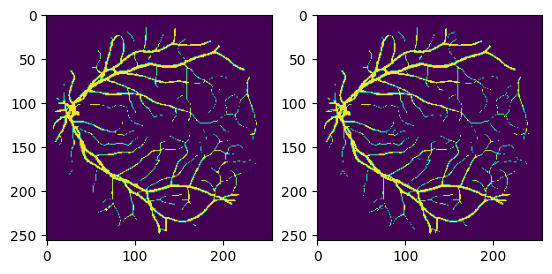

In [13]:
x, y = get_np_images(X_train, Y_train)
y_pred = model.predict(np.expand_dims(x[0], axis = 0))
# y_pred = y_pred > 0.5
# y_pred = y_pred.astype(np.int32)
f, plot = plt.subplots(1,2)
plot[0].imshow(y_pred[0])
plot[1].imshow(y[0])
plt.show();